# Sentiment Analysis with LSTM and GRU

In [1]:
import numpy as np 
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import *
from keras.layers import *
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

Using TensorFlow backend.


In [2]:
data = pd.read_csv('tweets_extracted.csv',encoding = 'latin-1')
# Keeping only the neccessary columns
data = data[['text','sentiment']]

I am filtering the tweets so only valid texts and words remain.  Then, I define the number of max features as 2000 and use Tokenizer to vectorize and convert text into Sequences so the Network can deal with it as input.

In [3]:
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['sentiment'] == 'positive'].size)
print(data[ data['sentiment'] == 'negative'].size)
print(data[ data['sentiment'] == 'neutral' ].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_features = 2000
tokenizer = Tokenizer(nb_words=max_features, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

890
4240
806


/home/sagar/anaconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:145: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Next, I compose the LSTM Network. Note that **embed_dim**, **lstm_out**, **batch_size**, **droupout_x** variables are hyperparameters, their values are somehow intuitive, can be and must be played with in order to achieve good results. Please also note that I am using softmax as activation function. The reason is that our Network is using categorical crossentropy, and softmax is just the right activation method for that.

In [4]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1], dropout=0.2))
model.add(LSTM(lstm_out, dropout=0.2))
#model.add(LSTM(lstm_out, dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

/home/sagar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  """


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 585, 128)          256000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 591       
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________
None


Hereby I declare the train and test dataset.

In [5]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2077, 585) (2077, 3)
(891, 585) (891, 3)


Here we train the Network. We should run much more than 7 epoch, but I would have to wait forever for kaggle, so it is 7 for now.

In [7]:
from sklearn.metrics import classification_report,confusion_matrix
import itertools

np.random.seed(11121)
epoch = 7
batch_size = 32
hist = model.fit(X_train, Y_train, nb_epoch = epoch, batch_size=batch_size, verbose = 2,validation_data=(X_test, Y_test))

train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=np.arange(7)


/home/sagar/anaconda3/lib/python3.6/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 2077 samples, validate on 891 samples
Epoch 1/7
174s - loss: 0.6614 - acc: 0.7670 - val_loss: 0.4673 - val_acc: 0.8316
Epoch 2/7
165s - loss: 0.3047 - acc: 0.8931 - val_loss: 0.2943 - val_acc: 0.9080
Epoch 3/7
167s - loss: 0.1673 - acc: 0.9504 - val_loss: 0.2974 - val_acc: 0.9113
Epoch 4/7
160s - loss: 0.1082 - acc: 0.9682 - val_loss: 0.3120 - val_acc: 0.9169
Epoch 5/7
158s - loss: 0.0887 - acc: 0.9726 - val_loss: 0.3123 - val_acc: 0.9012
Epoch 6/7
171s - loss: 0.0674 - acc: 0.9822 - val_loss: 0.3725 - val_acc: 0.8822
Epoch 7/7
169s - loss: 0.0778 - acc: 0.9754 - val_loss: 0.3264 - val_acc: 0.8990


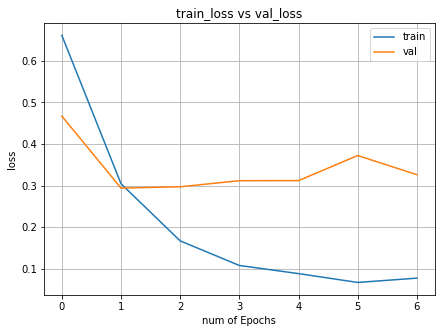

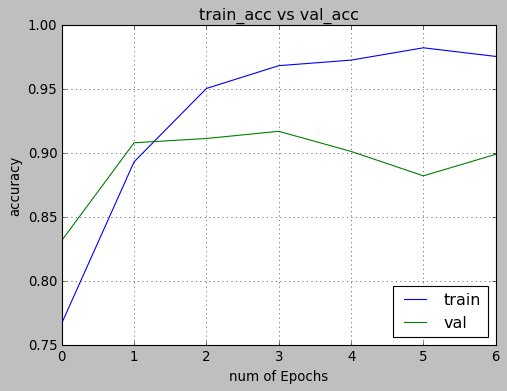

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print(plt.style.available) # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])


Extracting a validation set, and measuring score and accuracy.

In [9]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.33
acc: 0.90


In [10]:
Y_pred = model.predict(X_test)
print(Y_pred)
Y_pred = np.argmax(Y_pred, axis=1)
print(Y_pred)
#Y_pred = model.predict_classes(X_test)
#print(Y_pred)
target_names = ['class 0(negative)', 'class 1(positive)', 'class 2(neutral)']
					



[[  9.99264061e-01   3.81014892e-04   3.54830263e-04]
 [  4.69058484e-01   3.74283008e-02   4.93513256e-01]
 [  9.71795738e-01   1.25161465e-02   1.56880785e-02]
 ..., 
 [  9.99982476e-01   1.14002487e-05   6.02269893e-06]
 [  8.93068500e-04   4.47326631e-04   9.98659611e-01]
 [  8.20675135e-01   1.02753676e-01   7.65711814e-02]]
[0 2 0 0 1 0 0 0 0 0 2 2 0 0 2 0 1 0 1 2 2 0 0 0 0 0 2 0 0 0 0 0 2 0 2 0 0
 0 0 0 0 0 0 0 2 0 0 2 0 2 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1
 0 0 0 0 1 1 2 0 0 0 2 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 2 1 1 2 2 0
 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 2 0 0 0 2 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 1 1 0 0 0 0 0 0 2 2
 0 0 0 2 0 2 0 2 0 1 0 0 1 0 0 0 0 2 0 0 0 1 1 0 1 1 0 0 0 0 2 1 0 0 0 0 0
 0 0 0 1 2 1 1 0 2 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 2 1 0
 0 0 1 0 0 0 2 0 0 0 0 0 2 2 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 2 0 0 0 0 0 0
 0 0 0 0 2 0 0 0 2 0 0 1 2 0 0 2 0 0 0 0 1 1 1 0 2 0 0 0 1 0 2 0 0 0

In [11]:
print(classification_report(np.argmax(Y_test,axis=1), Y_pred,target_names=target_names))


                   precision    recall  f1-score   support

class 0(negative)       0.93      0.95      0.94       623
class 1(positive)       0.84      0.90      0.87       127
 class 2(neutral)       0.80      0.69      0.74       141

      avg / total       0.90      0.90      0.90       891



In [12]:
print(confusion_matrix(np.argmax(Y_test,axis=1), Y_pred))

[[590  12  21]
 [  9 114   4]
 [ 35   9  97]]


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [14]:
# Compute confusion matrix
cnf_matrix = (confusion_matrix(np.argmax(Y_test,axis=1), Y_pred))

Confusion matrix, without normalization
[[590  12  21]
 [  9 114   4]
 [ 35   9  97]]


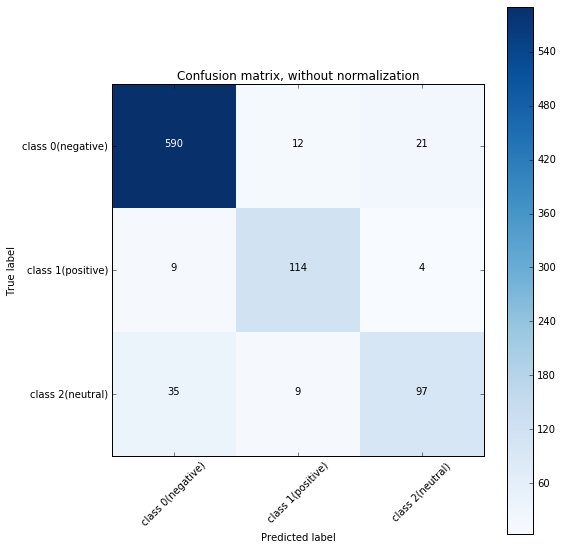

In [15]:
plot_confusion_matrix(cm=cnf_matrix, 
                      classes=target_names, 
                      normalize=False,
                          title='Confusion matrix, without normalization')

Normalized confusion matrix
[[ 0.9470305   0.01926164  0.03370787]
 [ 0.07086614  0.8976378   0.03149606]
 [ 0.24822695  0.06382979  0.68794326]]


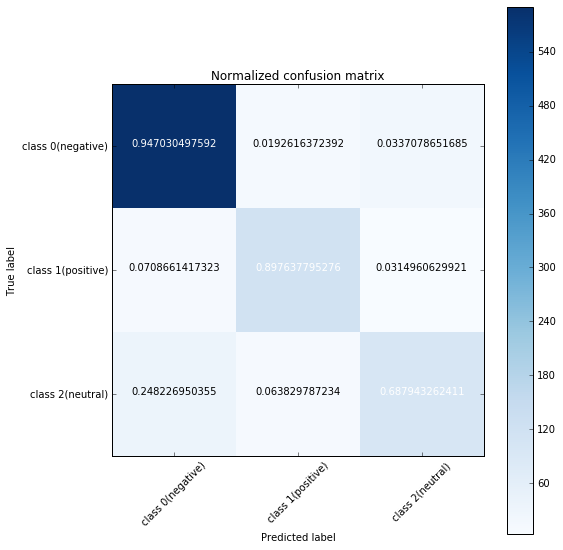

In [16]:
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

Finally measuring the number of correct guesses.  It is clear that finding negative tweets goes very well for the Network but deciding whether is positive is not really. My educated guess here is that the positive training set is dramatically smaller than the negative, hence the "bad" results for positive tweets.

In [17]:
pos_cnt, neg_cnt,neu_cnt, pos_correct, neg_correct, neu_correct = 0, 0, 0, 0, 0, 0
for x in range(len(X_test)):
    
    result = model.predict(X_test[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_test[x]):
        if np.argmax(Y_test[x]) == 0:
            neg_correct += 1
        elif np.argmax(Y_test[x]) == 1:
            pos_correct += 1
        else:
            neu_correct += 1
       
    if np.argmax(Y_test[x]) == 0:
        neg_cnt += 1
    elif np.argmax(Y_test[x]) == 1:
        pos_cnt += 1
    else:
        neu_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")
print("neu_acc", neu_correct/neu_cnt*100, "%")

pos_acc 89.76377952755905 %
neg_acc 94.70304975922953 %
neu_acc 68.79432624113475 %


# GRU

In [18]:

embed_dim = 256


model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1], dropout=0.2))
model.add(GRU(196, dropout=0.2))

model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

/home/sagar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 585, 256)          512000    
_________________________________________________________________
gru_1 (GRU)                  (None, 196)               266364    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 591       
Total params: 778,955
Trainable params: 778,955
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
from sklearn.metrics import classification_report,confusion_matrix
import itertools

np.random.seed(11121)
epoch = 7
batch_size = 40
hist = model.fit(X_train, Y_train, nb_epoch = epoch, batch_size=batch_size, verbose = 2,validation_data=(X_test, Y_test))

train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=np.arange(7)

/home/sagar/anaconda3/lib/python3.6/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 2077 samples, validate on 891 samples
Epoch 1/7
155s - loss: 0.6420 - acc: 0.7679 - val_loss: 0.4349 - val_acc: 0.8608
Epoch 2/7
152s - loss: 0.2649 - acc: 0.9167 - val_loss: 0.2641 - val_acc: 0.9012
Epoch 3/7
142s - loss: 0.1262 - acc: 0.9615 - val_loss: 0.2792 - val_acc: 0.9113
Epoch 4/7
145s - loss: 0.0754 - acc: 0.9793 - val_loss: 0.3318 - val_acc: 0.9113
Epoch 5/7
146s - loss: 0.0506 - acc: 0.9860 - val_loss: 0.3761 - val_acc: 0.8855
Epoch 6/7
150s - loss: 0.0418 - acc: 0.9884 - val_loss: 0.4095 - val_acc: 0.8945
Epoch 7/7
144s - loss: 0.0349 - acc: 0.9899 - val_loss: 0.4410 - val_acc: 0.9012


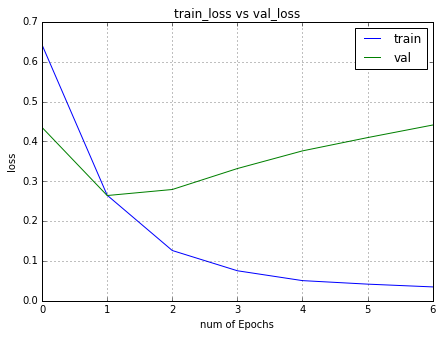

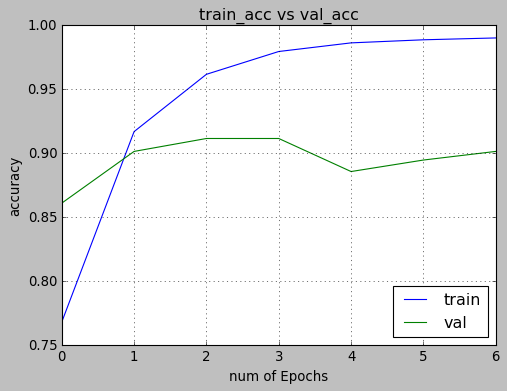

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print(plt.style.available) # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [21]:
Y_pred = model.predict(X_test)
print(Y_pred)
Y_pred = np.argmax(Y_pred, axis=1)
print(Y_pred)
#Y_pred = model.predict_classes(X_test)
#print(Y_pred)
target_names = ['class 0(negative)', 'class 1(positive)', 'class 2(neutral)']

[[  9.99977589e-01   9.17738998e-06   1.31991046e-05]
 [  5.42549849e-01   1.67372152e-02   4.40712899e-01]
 [  9.97556210e-01   1.03624468e-03   1.40746264e-03]
 ..., 
 [  9.99986768e-01   8.34654838e-06   4.94093274e-06]
 [  3.72947543e-04   2.71845696e-04   9.99355257e-01]
 [  7.13878870e-01   5.04032746e-02   2.35717878e-01]]
[0 0 0 0 1 0 0 0 0 0 2 0 0 0 2 0 1 0 1 2 2 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0
 0 0 0 0 0 0 0 2 0 0 2 0 2 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1
 0 0 0 0 1 1 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 2 1 1 2 2 0
 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 2 1 0 2 0 0 0 2 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 1 1 0 0 0 0 0 0 2 2
 0 0 0 2 0 2 0 2 0 1 0 0 1 0 0 0 0 2 0 0 0 1 1 0 1 1 0 0 0 0 2 1 0 0 0 0 0
 1 0 0 1 2 1 1 0 2 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 2 1 0
 0 0 1 0 0 0 2 0 0 0 0 0 2 2 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 2 0 0 0 0 0 0
 0 0 0 0 2 0 0 0 0 0 0 1 2 0 0 2 0 0 0 0 1 1 1 0 2 0 0 0 1 0 2 0 0 0

In [22]:
print(classification_report(np.argmax(Y_test,axis=1), Y_pred,target_names=target_names))

                   precision    recall  f1-score   support

class 0(negative)       0.93      0.95      0.94       623
class 1(positive)       0.85      0.90      0.87       127
 class 2(neutral)       0.80      0.70      0.75       141

      avg / total       0.90      0.90      0.90       891



In [23]:
print(confusion_matrix(np.argmax(Y_test,axis=1), Y_pred))

[[590  13  20]
 [  9 114   4]
 [ 35   7  99]]


In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
cnf_matrix = (confusion_matrix(np.argmax(Y_test,axis=1), Y_pred))

Confusion matrix, without normalization
[[590  13  20]
 [  9 114   4]
 [ 35   7  99]]


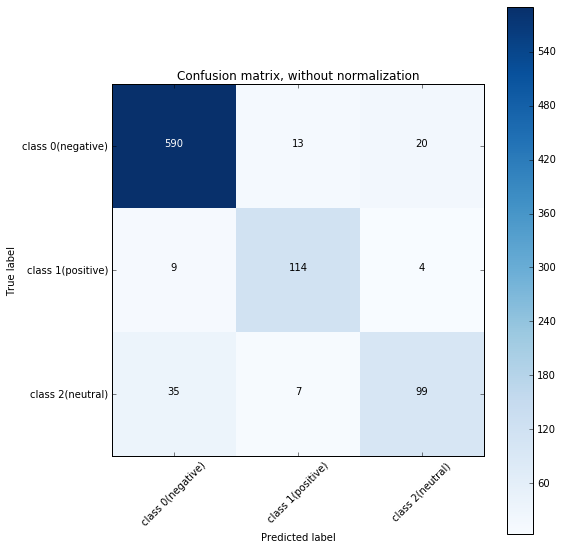

In [26]:
plot_confusion_matrix(cm=cnf_matrix, 
                      classes=target_names, 
                      normalize=False,
                          title='Confusion matrix, without normalization')

Normalized confusion matrix
[[ 0.9470305   0.02086677  0.03210273]
 [ 0.07086614  0.8976378   0.03149606]
 [ 0.24822695  0.04964539  0.70212766]]


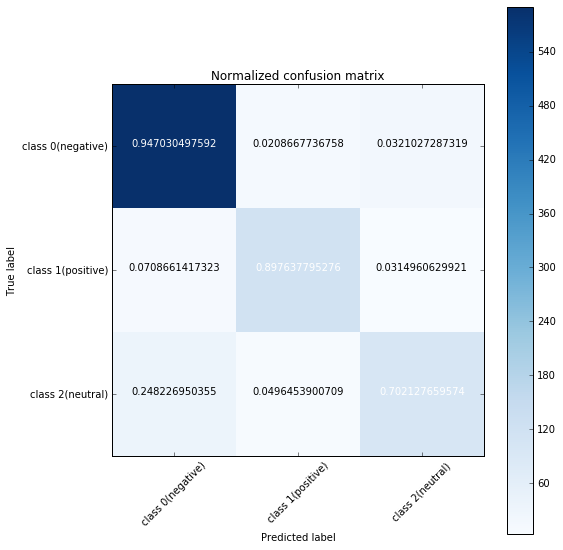

In [27]:
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

In [28]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.44
acc: 0.90


In [29]:
pos_cnt, neg_cnt,neu_cnt, pos_correct, neg_correct, neu_correct = 0, 0, 0, 0, 0, 0
for x in range(len(X_test)):
    
    result = model.predict(X_test[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_test[x]):
        if np.argmax(Y_test[x]) == 0:
            neg_correct += 1
        elif np.argmax(Y_test[x]) == 1:
            pos_correct += 1
        else:
            neu_correct += 1
       
    if np.argmax(Y_test[x]) == 0:
        neg_cnt += 1
    elif np.argmax(Y_test[x]) == 1:
        pos_cnt += 1
    else:
        neu_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")
print("neu_acc", neu_correct/neu_cnt*100, "%")

pos_acc 89.76377952755905 %
neg_acc 94.70304975922953 %
neu_acc 70.2127659574468 %
